In [27]:
import requests

Settings:

In [28]:
topic = "climate_change"
organizers = None  # ["Last Generation (Germany)"]

In [29]:
res = requests.post(
    # "https://api.dev.mediaimpactmonitor.app/events",
    "http://localhost:8000/events",
    json={
        "event_type": "protest",
        "source": "acled",
        "topic": "climate_change",
        "start_date": "2023-07-01",
        "end_date": "2023-12-31",
        "topic": topic,
        "organizers": organizers,
    },
)
events = res.json()["data"]
event_ids = [event["event_id"] for event in events]
events[0]

{'event_id': '7855aac104a8483f4c7a268b821af6ea',
 'event_type': 'protest',
 'source': 'acled',
 'date': '2023-12-22',
 'organizers': [],
 'description': "On 22 December 2023, 5 climate activists staged a protest in Ravensburg (Baden-Wurttemberg), highlighting the insufficient implementation of the Ravensburg Climate Consensus and questioned the city's progress on measures such as speed limit signs, new bus lines, and subsidies for the 49-euro ticket, while also condemning the spread of false information regarding the city's purported donation plans to a 'Climate Emergency Fund.'"}

In [49]:
import pandas as pd
import numpy as np
import altair as alt

df = pd.DataFrame(events)
df["organizer"] = df["organizers"].apply(lambda x: x[0] if x else "nooo")
df["y"] = np.random.normal(loc=0, scale=1, size=len(df))
df["participants"] = np.random.randint(100, 1000, size=len(df))
df.head()

alt.Chart(df).mark_circle().encode(
    x="date:T",  # T: temporal
    y="y:Q",  # Q: quantitative
    color="organizer:N",  # N: nominal
    size="participants:Q",  # Quantitative size encoding
).properties(width=600, height=300)

alt.Chart(...)

In [44]:
res = requests.post(
    # "https://api.dev.mediaimpactmonitor.app/trend",
    "http://localhost:8000/trend",
    json={
        "trend_type": "keywords",
        "media_source": "news_online",
        "topic": "climate_change",
        "query": '"Letzte Generation"',
        "start_date": "2023-01-01",
        "end_date": "2023-12-31",
    },
)
data = res.json()["data"]

In [48]:
df = pd.DataFrame(list(data.items()), columns=["date", "value"])
df["date"] = pd.to_datetime(df["date"])  # Convert the date column to datetime type

alt.Chart(df).mark_line(point=True).encode(
    x="date:T",  # T: temporal
    y="value:Q",  # Q: quantitative
    tooltip=["date", "value"],
).properties(width=600, height=300)

alt.Chart(...)

In [51]:
res = requests.post(
    # "https://api.dev.mediaimpactmonitor.app/impact",
    "http://localhost:8000/impact",
    json={
        "cause": event_ids,
        "effect": {
            "trend_type": "keywords",
            "media_source": "news_online",
            "topic": "climate_change",
            "query": '"Letzte Generation"',
        },
        "method": "interrupted_time_series",
    },
)
res.text
# data = res.json()["data"]

'{"detail":"AttributeError: \'Series\' object has no attribute \'columns\'"}'

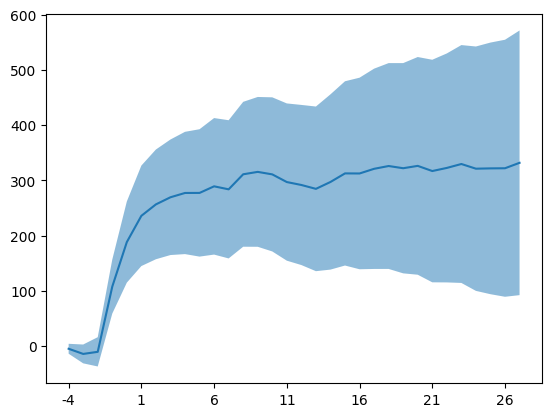

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

pd.Series(data["impact_average"]).plot()
plt.fill_between(
    pd.Series(data["impact_average"]).index,
    pd.Series(data["impact_average_lower"]).values,
    pd.Series(data["impact_average_upper"]).values,
    alpha=0.5,
)

count     151.000000
mean      296.960599
std       986.697558
min     -2133.562851
25%      -370.196449
50%       241.558525
75%      1440.875370
max      2044.068390
dtype: float64


<Axes: >

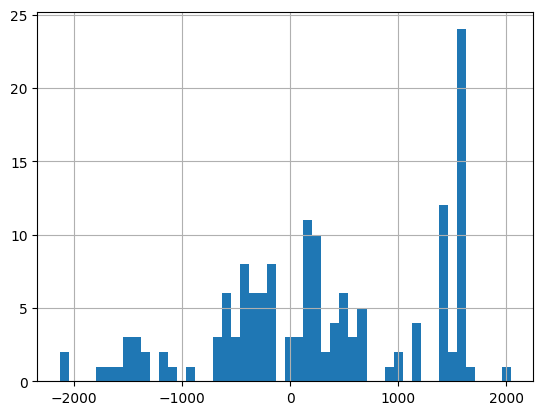

In [6]:
impacts__ = pd.Series(
    [list(ts.values())[4 + 14] for ts in data["individual_impacts"].values()]
)
print(impacts__.describe())
impacts__.hist(bins=50)

In [7]:
from scipy.stats import normaltest

normaltest(impacts__)

NormaltestResult(statistic=6.673493808306942, pvalue=0.03555242525322097)

Small p-value means that it's likely not normal. (However, large p-value does not mean anything, e. g. it can be due to small sample size.)
See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html.